## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [296]:
import numpy as np
import pandas as pd
from scipy import sparse
import math
from collections import Counter
import matplotlib.pyplot as plt
from scipy.sparse.linalg import norm
%matplotlib inline

In [2]:
user_rate = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')

In [3]:
user_rate_test = pd.DataFrame(columns=[user_rate.columns])
user_rate_val = pd.DataFrame(columns=[user_rate.columns])

In [4]:
for u in set(user_rate['userID'].values):
    user_rate_test = user_rate_test.append(user_rate.loc[user_rate['userID']==u].sort_values(['timestamp'],ascending=False).iloc[:5])

In [5]:
for u in set(user_rate['userID'].values):
    user_rate_val = user_rate_val.append(user_rate.loc[user_rate['userID']==u].sort_values(['timestamp'],ascending=False).iloc[5:10])

In [6]:
user_rate_train = pd.concat([user_rate, user_rate_test, user_rate_val]).drop_duplicates(keep=False) #удаляет оба дубликата

In [385]:
user_rate_test.head(20)

,userID,movieID,rating,timestamp
98105,8194,44191,3.0,1171275668000
98103,8194,5349,4.0,1171275665000
98096,8194,2640,3.5,1171275662000
98100,8194,3793,4.0,1171275656000
98107,8194,49647,4.0,1171275590000
195543,16389,57223,3.5,1230563196000
195298,16389,3702,3.0,1230563163000
195299,16389,3703,2.5,1230563158000
195208,16389,2371,3.5,1230563143000
195546,16389,59501,4.0,1229757784000


In [15]:
test_table = user_rate_test.pivot_table(values='rating',index='userID',columns='movieID',fill_value=0)
val_table = user_rate_val.pivot_table(values='rating',index='userID',columns='movieID',fill_value=0)
train_table = user_rate_train.pivot_table(values='rating',index='userID',columns='movieID',fill_value=0)

In [387]:
test_table.head(20)

movieID,1,2,3,4,5,6,7,10,11,16,...,64976,64983,64986,64990,64997,65011,65037,65126,65130,65133
userID,,,,,,,,,,,,,,,,,,,,,
75,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0
78,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0
127,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0
170,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0
175,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0
190,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0
267,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0
325,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0
383,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0


In [16]:
test = sparse.csr_matrix(test_table.values)

In [17]:
val = sparse.csr_matrix(val_table.values)

In [18]:
train = sparse.csr_matrix(train_table.values)

Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [145]:
def rmse_score(y_true, y_predicted, k=5):
    #import pdb; pdb.set_trace()
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted
        
    scores = []
    for u in range(y_predicted_.shape[0]):
        order = np.argsort(y_predicted_[u])[::-1]
        scores.append(np.sqrt(np.power(y_true_[u][order[:k]]-y_predicted_[u][order[:k]],2).mean()))
    return np.mean(scores)


In [393]:
def ndcg_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted
    #import pdb; pdb.set_trace()
    # YOUR CODE IS HERE
    scores = []
    for u in range(y_predicted_.shape[0]):
        order = np.argsort(y_predicted_[u])[::-1]
        #pred_top = y_predicted_[u][order[:k]].copy()
        true_top = y_true_[u][order[:k]].copy()
        #true_top_sort = np.sort(true_top)[::-1]
        max_top = np.sort(y_true_[u])[::-1][:k]
        dcg = 0
        idcg = 0
        for i in range(true_top.shape[0]):
            dcg += (2**true_top[i]-1)/math.log(i+2)
        for i in range(max_top.shape[0]):
            idcg += (2**max_top[i]-1)/math.log(i+2)
        
        scores.append(dcg/idcg)
    #print(len(scores))
    return np.mean(scores)

In [394]:
ndcg_score(test,test,5)

1.0

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [383]:
test.shape

(2113, 3299)

In [115]:
most_pop = np.zeros((test.shape[0], test.shape[1]))
for i in range(test.shape[1]):
    col = test[:,i].toarray()
    most_pop[:,i] = np.tile([col[np.where(col!=0)].mean()],(test.shape[0],))

In [395]:
rmse_score(test, most_pop, k=5)

4.998750913286794

In [396]:
ndcg_score(test, most_pop, k=5)

0.00073187451046233276

**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [397]:
from sklearn.decomposition import TruncatedSVD

In [398]:
comps = np.arange(100,1100,100)

In [447]:
rmse_scores = []
ndcg_scores = []
recs = []
for c in comps:
    trs = TruncatedSVD(n_components=c)
    temp = trs.fit_transform(val)
    #print(temp.shape)
    val_rec = trs.inverse_transform(temp)
    recs.append(val_rec)
    rmse_scores.append(rmse_score(val,val_rec))
    ndcg_scores.append(ndcg_score(val,val_rec))

In [400]:
rmse_scores

[1.2292137571571435,
 1.4872003234211495,
 1.5144520517375715,
 1.4355931113326765,
 1.3216667907874056,
 1.1913334208449333,
 1.0580456713139086,
 0.92832489029867937,
 0.799613663560097,
 0.67908329450454574]

In [402]:
ndcg_scores

[0.45627962811062101,
 0.64490709731564244,
 0.7550523894606358,
 0.82086554845966186,
 0.86723886912964954,
 0.89915789299501714,
 0.9241350861078883,
 0.94238417723637102,
 0.95580915212450557,
 0.96633556434929546]

Text(0.5,1,'График зависимости RMSE от ранга разложения.')

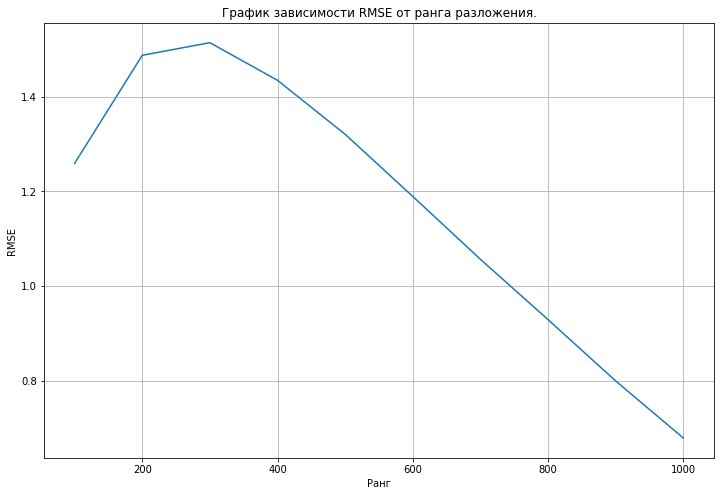

In [459]:
plt.figure(figsize=(12,8))
plt.plot(comps,rmse_scores)
plt.grid(True)
plt.xlabel('Ранг')
plt.ylabel('RMSE')
plt.title('График зависимости RMSE от ранга разложения.')

Text(0.5,1,'График зависимости nDCG от ранга разложения.')

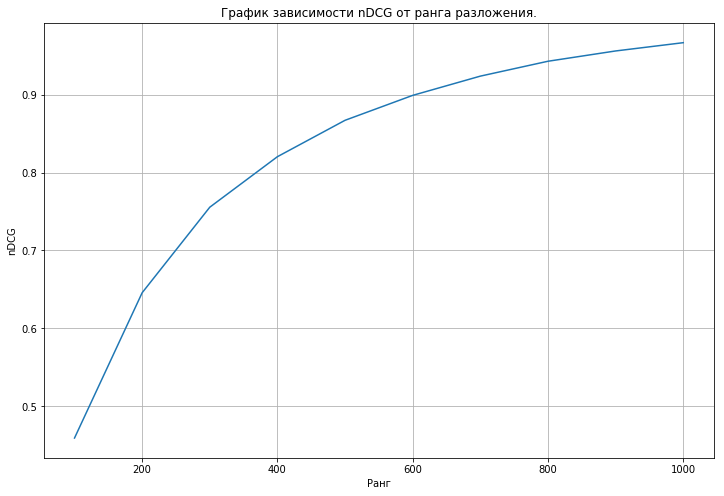

In [460]:
plt.figure(figsize=(12,8))
plt.plot(comps,ndcg_scores)
plt.grid(True)
plt.xlabel('Ранг')
plt.ylabel('nDCG')
plt.title('График зависимости nDCG от ранга разложения.')

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

In [307]:
def cos_sim(a,b):
    return (a.dot(b.transpose()))/(np.linalg.norm(a)*np.linalg.norm(b))

In [439]:
def create_afmat(mat_,method='cos'): # рассчет матрицы сходства
    if type(mat_) == sparse.csr.csr_matrix:
        mat = mat_.toarray()
    else:
        mat = mat_
    afmat = np.zeros((mat.shape[0],mat.shape[0]))
    for i in range(mat.shape[0]):
        for j in range(mat.shape[0]):
            if method == 'cos':
                afmat[i,j] = cos_sim(mat[i,:],mat[j,:])
            elif method == 'corr':
                afmat[i,j] = np.corrcoef(mat[i,:],mat[j,:])[0,1]
    return afmat

In [423]:
def count_means(mat_):
    if type(mat_) == sparse.csr.csr_matrix:
        mat = mat_.toarray()
    else:
        mat = mat_
    means = np.zeros(mat.shape[0])
    for i in range(mat.shape[0]):
        means[i] = np.mean(mat[i,:][np.where(mat[i,:]!=0)])
    return means

In [424]:
from IPython.display import clear_output

In [438]:
def user_colab(mat_,alpha,method='cos'):
    if type(mat_) == sparse.csr.csr_matrix:
        mat = mat_.toarray()
    else:
        mat = mat_
    pred_mat = np.zeros((mat.shape[0],mat.shape[1]))
    affin_mat = create_afmat(mat)
    means = count_means(mat)
    for i in range(mat.shape[0]):
        ks = []
        for k in np.delete(np.arange(mat.shape[0]),i):
            if affin_mat[i,k] >= alpha:
                ks.append(k)
        for j in range(mat.shape[1]):
            ch = 0
            zn = 0
            for k in ks:
                ch += affin_mat[i,k]*(mat[k,j]-means[k])
                zn += affin_mat[i,k]
            
            if zn != 0:
                pred_mat[i,j] = means[i] + ch/zn
            else:
                pred_mat[i,j] = means[i]
        
        print('Done ',i)
        clear_output(wait=True)
    return pred_mat

Применим user-based коллаборативную фильрацию с параметром $\alpha$ = 0.2 с мерой сходства - корреляция Пирсона.

In [426]:
v1 = user_colab(test,0.2,'corr')

Done  2112


In [427]:
rmse_score(test,v1)

1.9183417751796519

In [428]:
ndcg_score(test,v1)

0.65356233170951394

Применим user-based коллаборативную фильрацию с параметром $\alpha$ = 0.2 с косинусной мерой сходства.

In [430]:
v2 = user_colab(test,0.2.'cos')

Done  2112


In [431]:
rmse_score(test,v2)

1.9246436970335756

In [432]:
ndcg_score(test,v2)

0.65414953067242299

Применим user-based коллаборативную фильрацию с параметром $\alpha$ = 0.9 с косинусной мерой сходства.

In [433]:
v3 = user_colab(test,0.9,'cos')

Done  2112


In [434]:
rmse_score(test,v3)

3.5948761672691312

In [435]:
ndcg_score(test,v3)

0.00080340826311044731

При $\alpha$ = 0.9, работает плохо, так как нет пользователей с коэффициентом похожести не меньше 0.9, в таком случае метод выдает просто среднюю оценку пользователя без поправуи на коллаборацию.

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

При сравнении методов стоит понимать, что очень большое число рейтингов для фильмов неизвестно, поэтому RMSE получалась завышенной, а nDCG - наоборот, заниженной. 

Тем не менее, можно сказать, что эвристика подхода most popular - выдавать среднюю оценку для фильма слишком проста, чтобы хорошо работать для индивидуальных рекомендаций, ужасные результаты на метриках это подтверждают. Очевидно, этот подход плох тем, что он совершенно не учитывает индивидуальные предпочтения пользователя. 

Метод с разреженным SVD с точки зрения метрик в некоторой степени можно считать лучшим, однако стоит понимать, что цель SVD - построить лучшее приближение исходной матрицы, матрицей заданного ранга. Таким образом при больших значениях ранга разложения (при которых получаем хорошие оценки с точки зрения метрик), на выходе метода получим матрицу очень близкую к исходной и, например, не сделаем разумных прогнозов рейтингов для фильмов, которые пользователь не смотрел (рейтинги останутся близкими к нулю, при малом значении ранга эта ситуация сильно не меняется).

User-based коллаборативная фильтрация показала вполне адекватные результаты, при этом она позволяет проставить разумные оценки фильмам, которые пользователь не смотрел. Ошибка RMSE - 1,9 большая, но стоит помнить о том, что в матрице test очень мало известных рейтингов. Метрика nDCG также пострадала от нехватки большого числа рейтингов но все же показывает результат 0.65. Поскольку значение nDCG $\in [0,1]$, можно сделать вывод, что модель все же ранжирует фильмы лучше чем случайным образом.

**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?